In [10]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

In [8]:
def auto_correlation_graph(data, weeks):
    acf = sm.tsa.stattools.acf(data, nlags=int(2016*weeks), fft=False, adjusted=True)

    plt.figure(figsize=(12,6))
    plt.plot(acf)
    plt.axhline(y=0, color='red')
    plt.title(f"Autocorrelation Function Graph ~ {weeks} week(s)")
    plt.show()

In [3]:
power_demand = pd.read_csv('./data/power_demand_interpolated.csv')
power_demand['기준일시'] = pd.to_datetime(power_demand['기준일시'])
power_demand.rename(columns={'기준일시':'datetime', '현재수요(MW)':'load'}, inplace=True)

In [5]:
power_demand = power_demand.set_index("datetime")

In [9]:
power_demand = power_demand.loc['2020-01-01':'2023-03-19']

In [108]:
test_result_1week_adjusted = sm.tsa.stattools.acf(power_demand['load'], nlags=2016, fft=False, adjusted=True)
test_result_3mon_adjusted = sm.tsa.stattools.acf(power_demand['load'], nlags=26208, fft=False, adjusted=True)
test_result_6mon_adjusted = sm.tsa.stattools.acf(power_demand['load'], nlags=52416, fft=False, adjusted=True)
test_result_year_adjusted = sm.tsa.stattools.acf(power_demand['load'], nlags=104832, fft=False, adjusted=True)

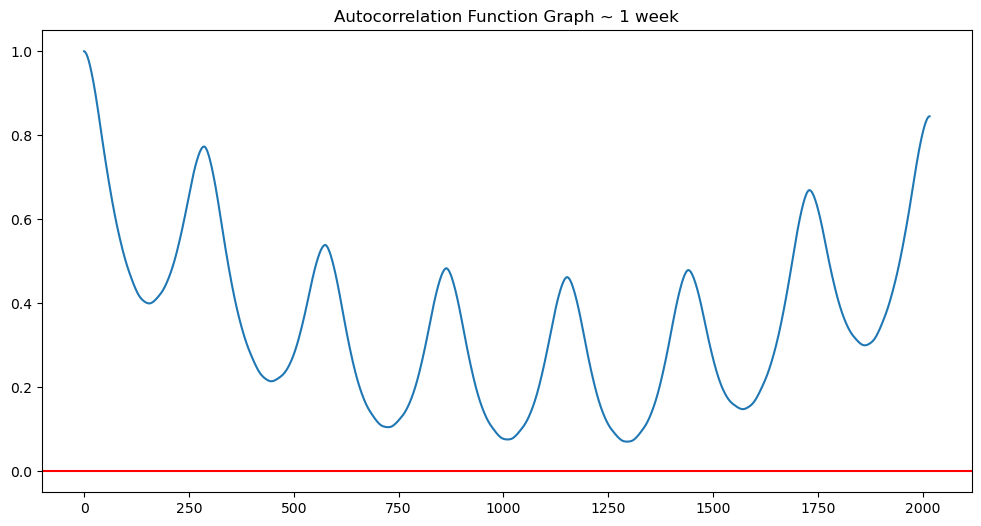

In [109]:
plt.figure(figsize=(12,6))
plt.plot(test_result_1week_adjusted)
plt.axhline(y=0, color='red')
plt.title("Autocorrelation Function Graph ~ 1 week")
plt.show()

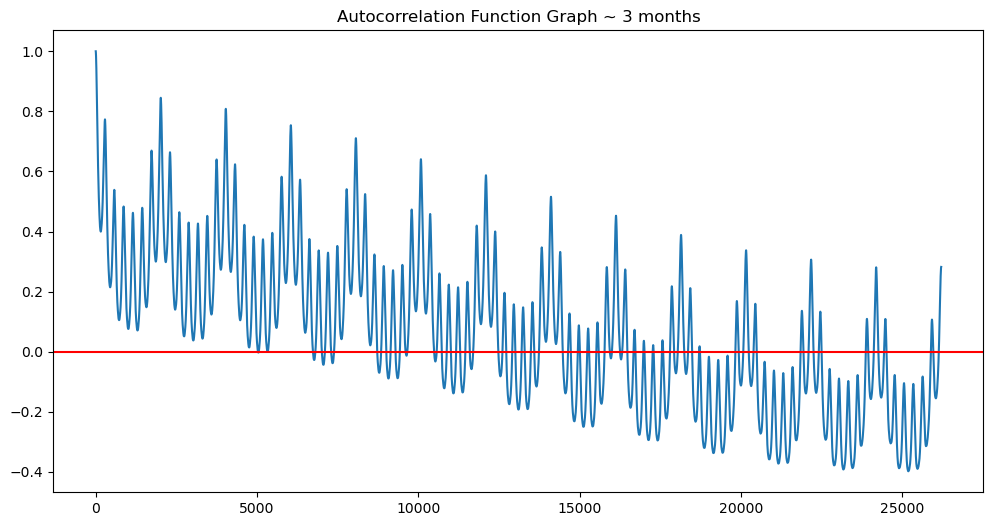

In [110]:
plt.figure(figsize=(12,6))
plt.plot(test_result_3mon_adjusted)
plt.axhline(y=0, color='red')
plt.title("Autocorrelation Function Graph ~ 3 months")
plt.show()

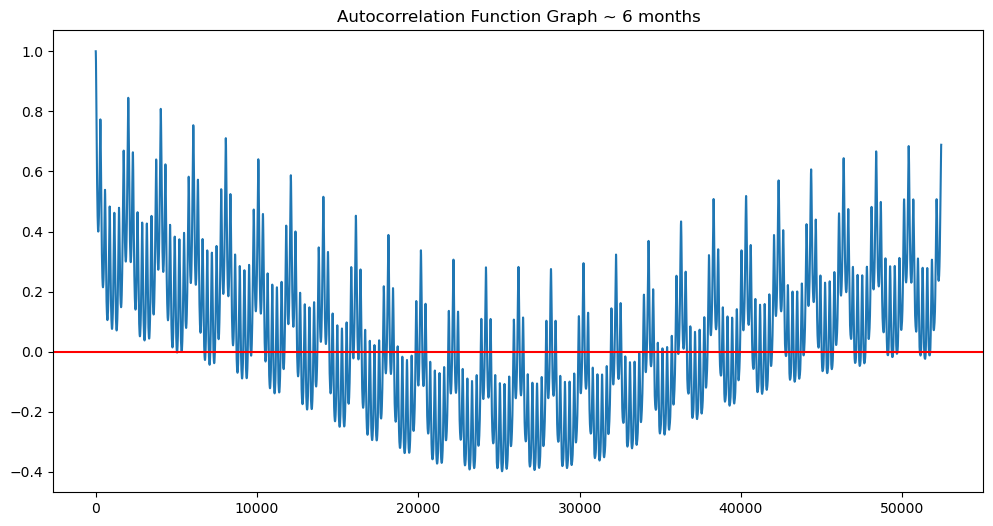

In [111]:
plt.figure(figsize=(12,6))
plt.plot(test_result_6mon_adjusted)
plt.axhline(y=0, color='red')
plt.title("Autocorrelation Function Graph ~ 6 months")
plt.show()

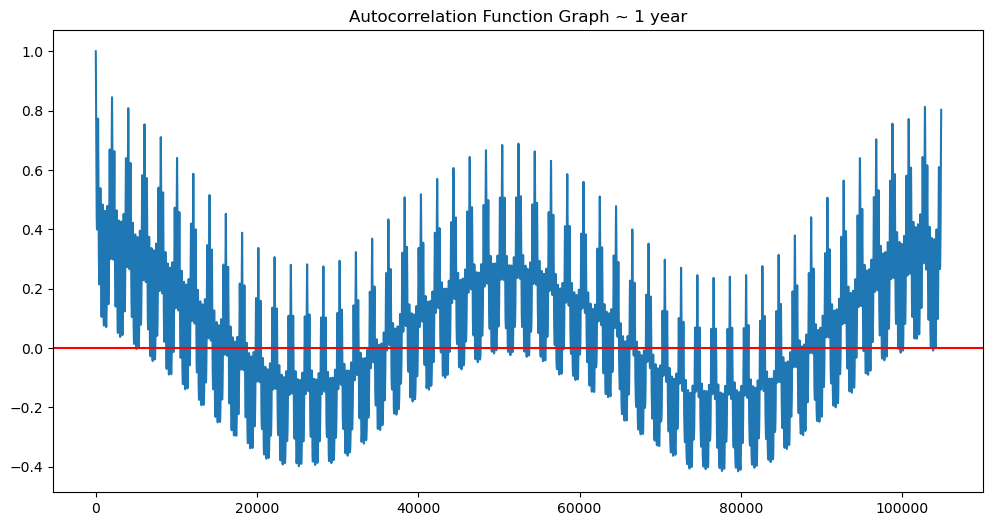

In [112]:
plt.figure(figsize=(12,6))
plt.plot(test_result_year_adjusted)
plt.axhline(y=0, color='red')
plt.title("Autocorrelation Function Graph ~ 1 year")
plt.show()

In [1]:
def generate_target_df(weather_metadata_path, weather_5minute_ASOS_path, holiday_path, power_path):

  import pandas as pd

  # 기상관측 MetaData 불러오기
  weather_metadata = pd.read_csv(weather_metadata_path)
  STN_dict = {STN_name : STN_num for STN_num, STN_name in zip(weather_metadata['지점'], weather_metadata['지점명'])}
  target_STN_list = [STN_dict[STN_name] for STN_name in ['서울', '부산', '인천', '대구', '대전', '광주', '원주']]

  # 서울 포함 7개 도시의 기온 및 일사량 데이터 불러오기
  weather_5minute = pd.read_parquet(weather_5minute_ASOS_path).astype({'지점' : 'int'})
  weather_5minute = weather_5minute[weather_5minute['지점'].isin(target_STN_list)]
  weather_5minute = weather_5minute[['지점', '일시', '기온(°C)', '일사(MJ/m^2)']]
  weather_5minute.columns = ['지점', '일시', '기온', '일사']

  column_list = ['기온', '일사']

  # 선형보간법 사용하여 결측값 채우기
  for idx, STN in enumerate(target_STN_list):

      # ① 각 STN별로 데이터 나누기
      tmp = weather_5minute[weather_5minute['지점'] == STN]

      # ② 시간순으로 정렬하기
      tmp = tmp.sort_values(by='일시')

      # ③ 선형보간법을 사용하여 nan값 채우기                
      for column in column_list:
        tmp[column] = tmp[column].interpolate(method='linear')

      # ④ tmp 합치기
      if idx == 0:
        interpolated_weather = tmp
      else:
        interpolated_weather = pd.concat([interpolated_weather, tmp])

  # 전국 기상 대표값 정하기 (최고기온, 최저기온, 평균일사량)
  for idx, column in enumerate(column_list):
    if column == '기온':
      # 최고 기온
      tmp_1 = pd.DataFrame(interpolated_weather.groupby('일시', as_index = False)[column].max()).rename(columns = {'기온' : 'max_temp'})
      # 최저 기온
      tmp_2 = pd.DataFrame(interpolated_weather.groupby('일시', as_index = False)[column].min()).rename(columns = {'기온' : 'min_temp'})
      tmp = pd.merge(tmp_1, tmp_2, on = '일시', how = 'inner')
    else:
      # 평균 일사량
      tmp = pd.DataFrame(interpolated_weather.groupby('일시', as_index = False)[column].mean()).rename(columns = {'일사' : 'mean_insolation'})
    # ② groupby 결과를 인덱스 기준으로 Join
    if idx == 0:
      representative_weather = tmp
    else:
      representative_weather = pd.merge(representative_weather, tmp, on = '일시', how = 'inner')

  representative_weather.rename(columns = {'일시' : 'datetime'}, inplace= True)

  return target_df

In [24]:
weather_metadata_path = './data/weather_localcenter_metadata.csv'
weather_5minute_ASOS_path = './data/weather_5minute_ASOS_2020-2023.parquet'
holiday_path = './data/holidays.csv'
power_path = './data/power_demand_interpolated.csv'

target_df = generate_target_df(weather_metadata_path, weather_5minute_ASOS_path, holiday_path, power_path)

In [7]:
target_df = target_df.iloc[:,1:4]

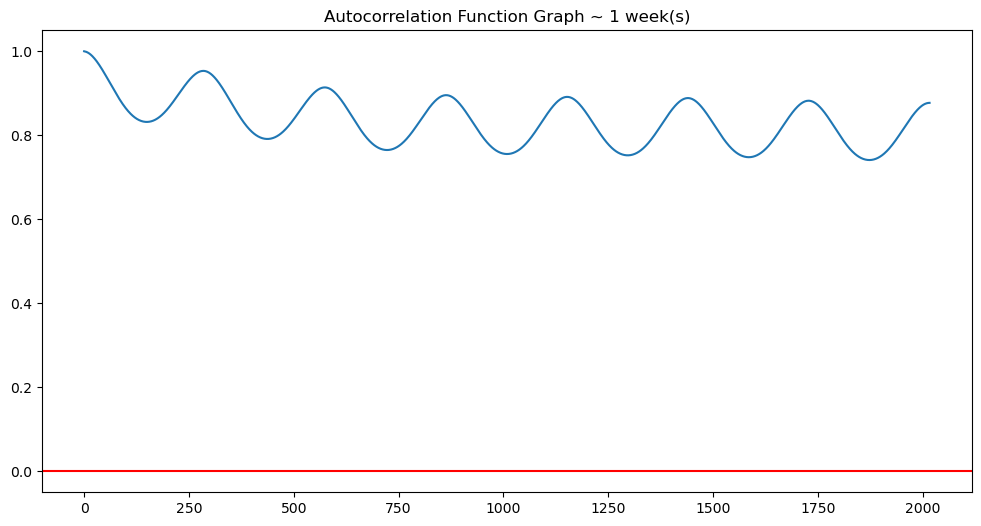

In [12]:
auto_correlation_graph(target_df.iloc[:,0], 1)

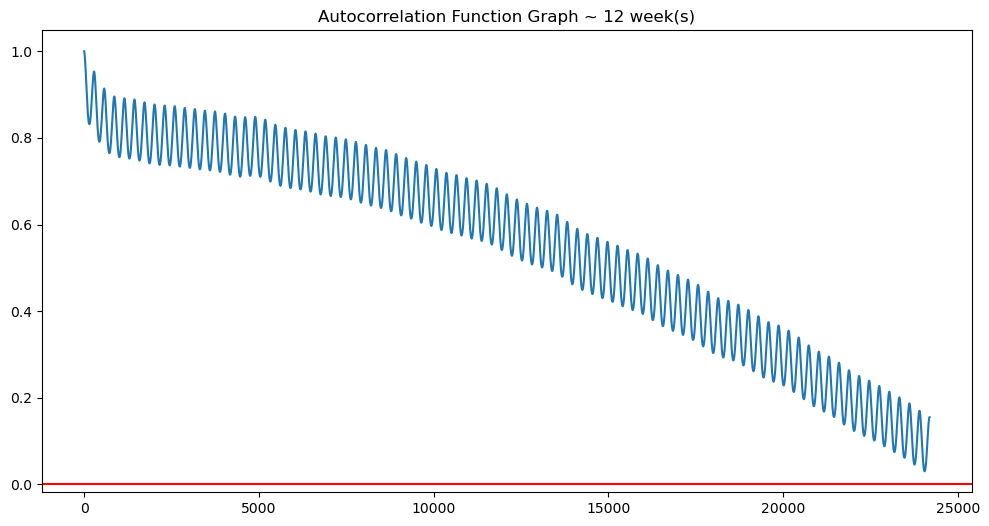

In [13]:
auto_correlation_graph(target_df.iloc[:,0], 12)

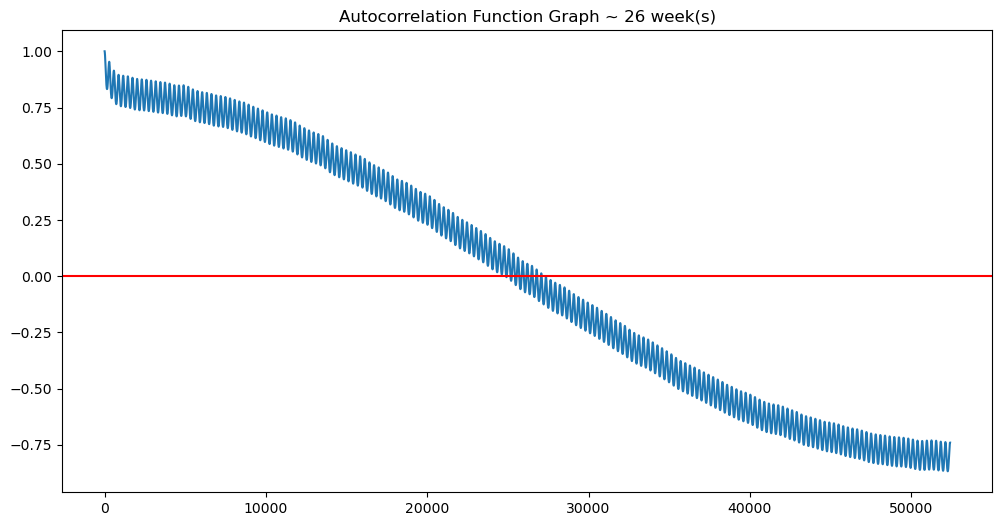

In [14]:
auto_correlation_graph(target_df.iloc[:,0], 26)

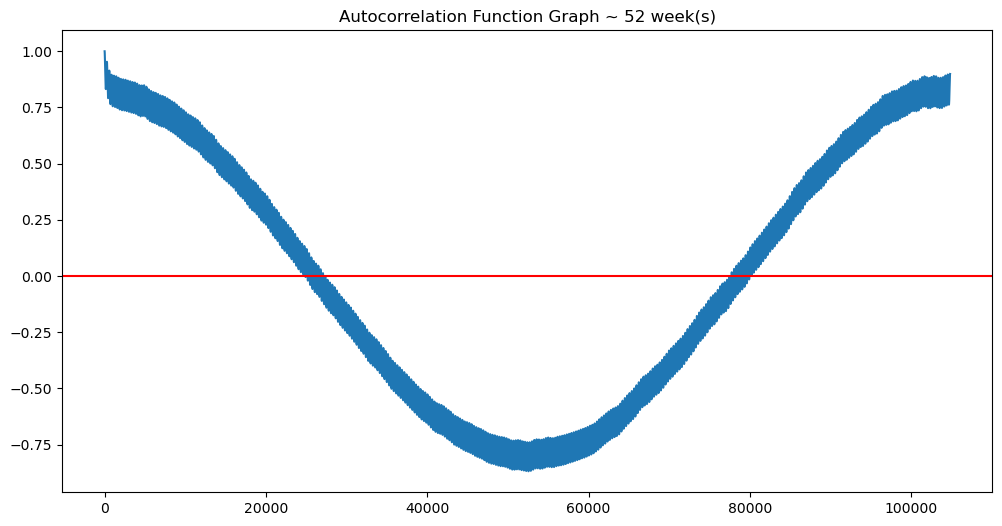

In [15]:
auto_correlation_graph(target_df.iloc[:,0], 52)

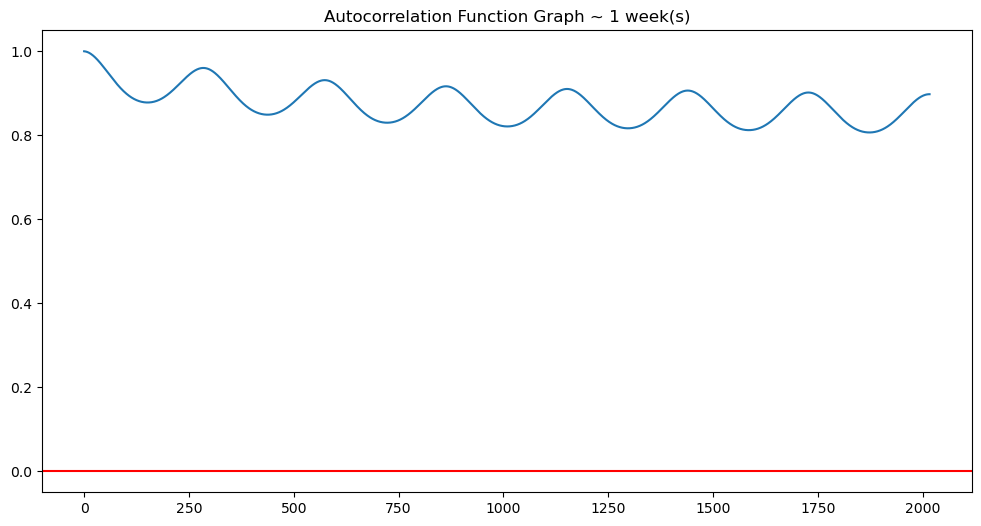

In [16]:
auto_correlation_graph(target_df.iloc[:,1], 1)

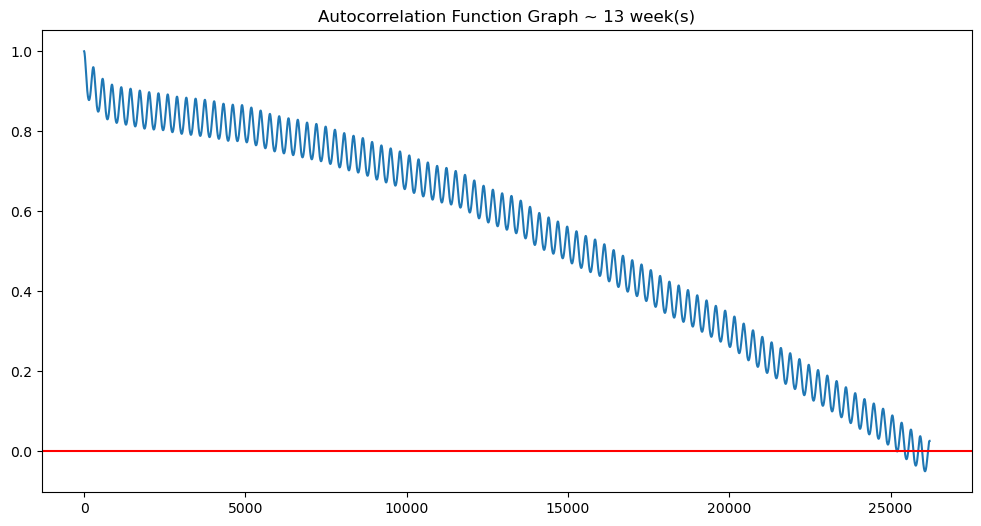

In [17]:
auto_correlation_graph(target_df.iloc[:,1], 13)

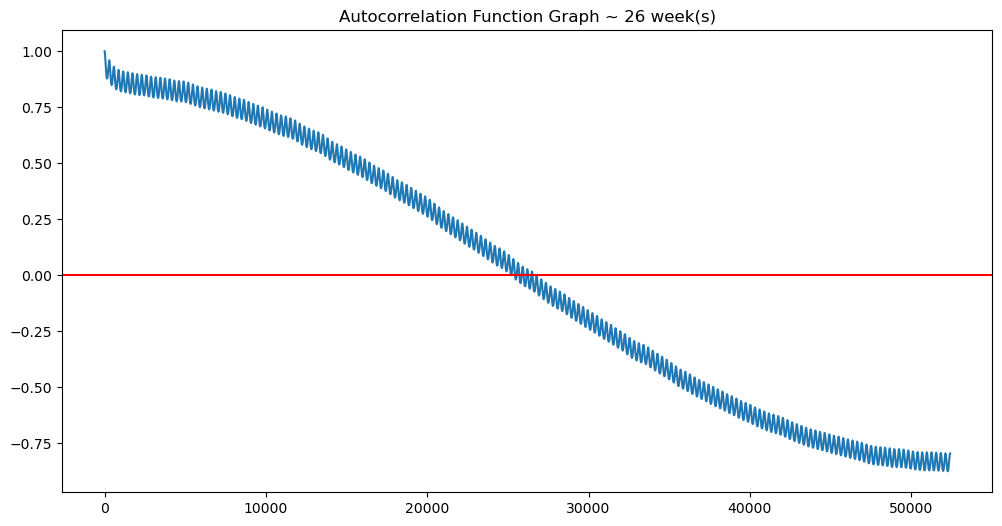

In [18]:
auto_correlation_graph(target_df.iloc[:,1], 26)

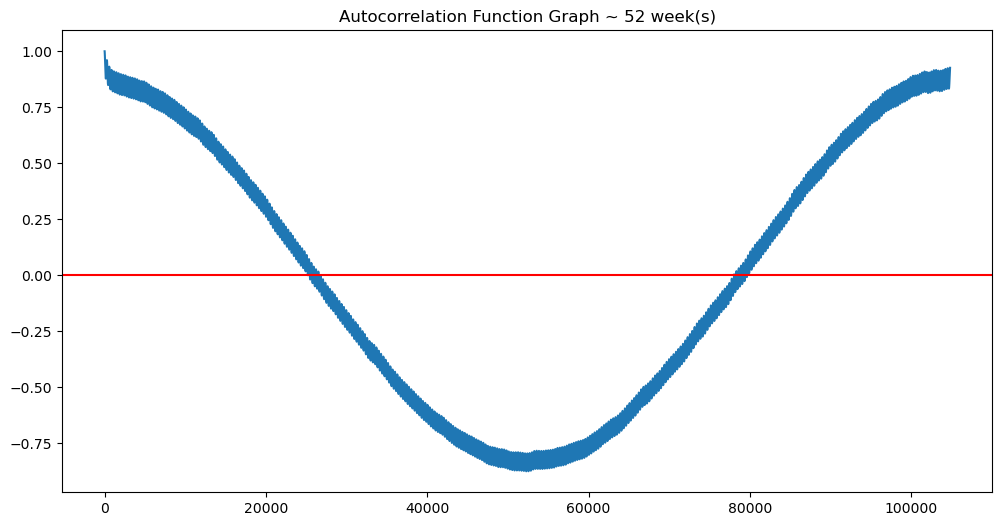

In [19]:
auto_correlation_graph(target_df.iloc[:,1], 52)

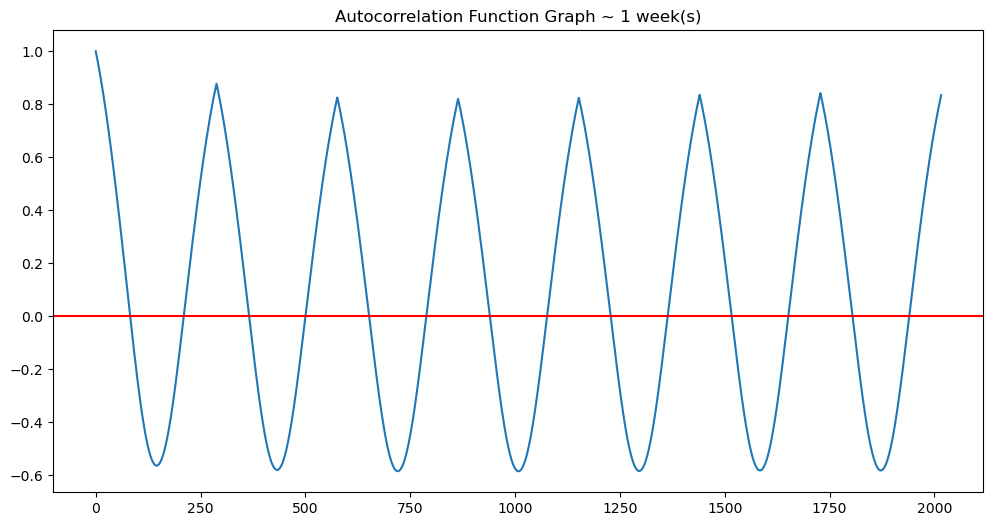

In [20]:
auto_correlation_graph(target_df.iloc[:,2], 1)

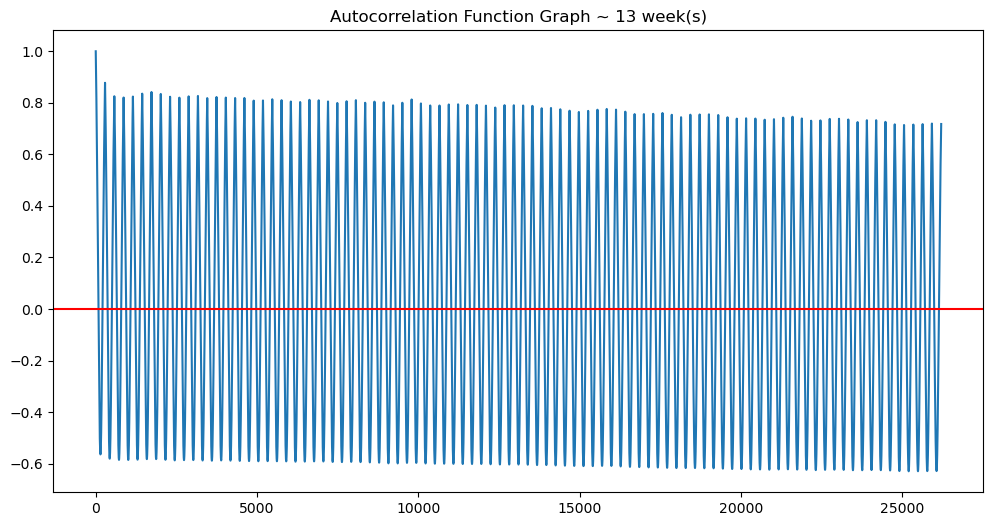

In [21]:
auto_correlation_graph(target_df.iloc[:,2], 13)

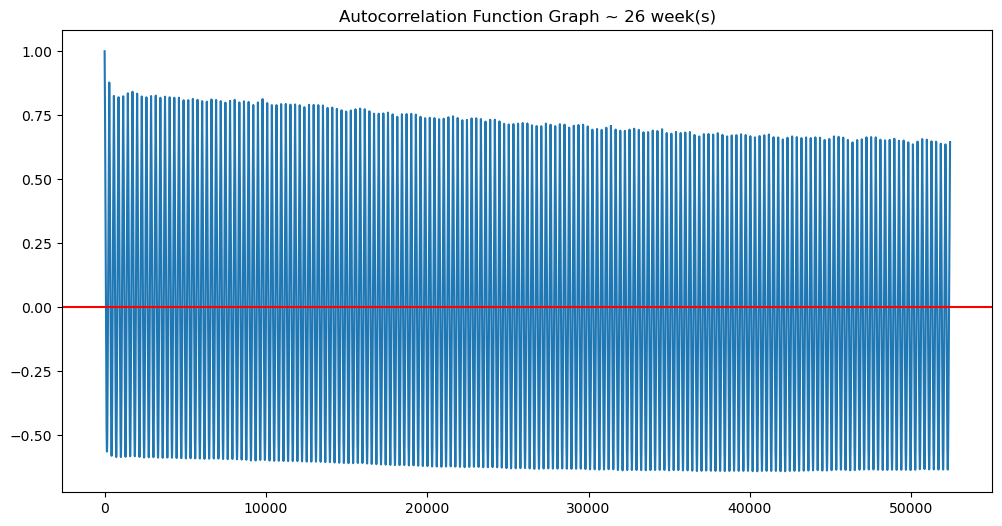

In [22]:
auto_correlation_graph(target_df.iloc[:,2], 26)

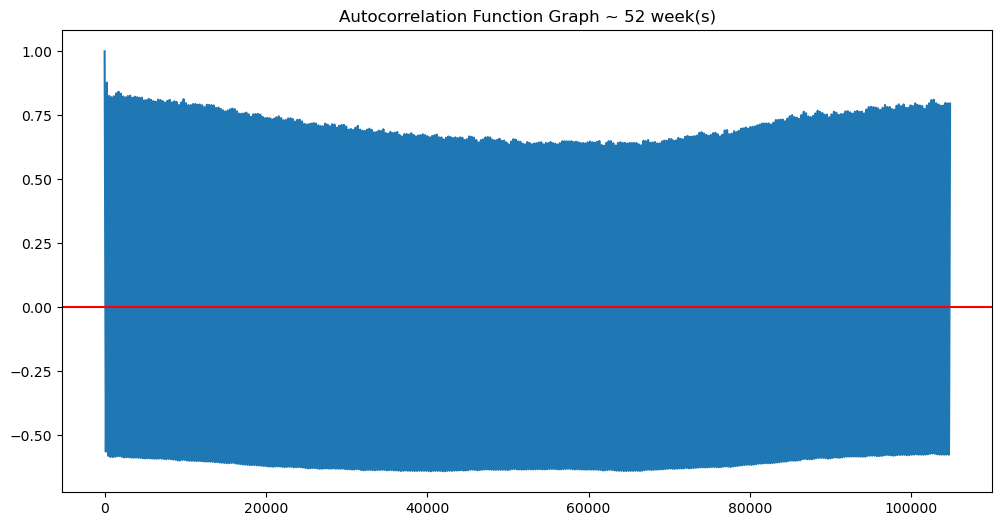

In [23]:
auto_correlation_graph(target_df.iloc[:,2], 52)

In [36]:
target_df = target_df[['max_temp', 'min_temp', 'mean_insolation', 'load']]

In [39]:
target_df['lag_max_temp'] = target_df['max_temp'].shift(1)
target_df['lag_min_temp'] = target_df['min_temp'].shift(1)
target_df['lag_mean_insolation'] = target_df['mean_insolation'].shift(1)
target_df['lag_load'] = target_df['load'].shift(1)
target_df

,max_temp,min_temp,mean_insolation,load,lag_max_temp,lag_min_temp,lag_mean_insolation,lag_load
0,-2.5,-7.6,0.000000,65295.7,NaN,NaN,NaN,NaN
1,-2.6,-7.6,0.000000,65098.7,-2.5,-7.6,0.000000,65295.7
2,-2.5,-7.6,0.001429,64927.2,-2.6,-7.6,0.000000,65098.7
3,-2.6,-7.6,0.001429,64480.8,-2.5,-7.6,0.001429,64927.2
4,-2.6,-7.7,0.002857,64438.3,-2.6,-7.6,0.001429,64480.8
...,...,...,...,...,...,...,...,...
338106,10.4,1.9,21.630000,58627.2,10.4,1.9,21.630000,58949.8
338107,10.4,1.9,21.631429,57941.2,10.4,1.9,21.630000,58627.2
338108,10.4,1.8,21.631429,57726.2,10.4,1.9,21.631429,57941.2
338109,10.4,1.8,21.632857,57755.4,10.4,1.8,21.631429,57726.2


In [40]:
target_df['delta_max_temp_ratio'] = (target_df['max_temp'] - target_df['lag_max_temp']) / target_df['max_temp']
target_df['delta_min_temp_ratio'] = (target_df['min_temp'] - target_df['lag_min_temp']) / target_df['min_temp']
target_df['delta_mean_insolation_ratio'] = (target_df['mean_insolation'] - target_df['lag_mean_insolation']) / target_df['mean_insolation']
target_df['delta_load_ratio'] = (target_df['load'] - target_df['lag_load']) / target_df['load']

In [41]:
target_df['max_load'] = target_df['delta_max_temp_ratio'] / target_df['delta_load_ratio']

,max_temp,min_temp,mean_insolation,load,lag_max_temp,lag_min_temp,lag_mean_insolation,lag_load,delta_max_temp_ratio,delta_min_temp_ratio,delta_mean_insolation_ratio,delta_load_ratio
0,-2.5,-7.6,0.000000,65295.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-2.6,-7.6,0.000000,65098.7,-2.5,-7.6,0.000000,65295.7,0.038462,-0.000000,NaN,-0.003026
2,-2.5,-7.6,0.001429,64927.2,-2.6,-7.6,0.000000,65098.7,-0.040000,-0.000000,1.000000,-0.002641
3,-2.6,-7.6,0.001429,64480.8,-2.5,-7.6,0.001429,64927.2,0.038462,-0.000000,0.000000,-0.006923
4,-2.6,-7.7,0.002857,64438.3,-2.6,-7.6,0.001429,64480.8,-0.000000,0.012987,0.500000,-0.000660
...,...,...,...,...,...,...,...,...,...,...,...,...
338106,10.4,1.9,21.630000,58627.2,10.4,1.9,21.630000,58949.8,0.000000,0.000000,0.000000,-0.005503
338107,10.4,1.9,21.631429,57941.2,10.4,1.9,21.630000,58627.2,0.000000,0.000000,0.000066,-0.011840
338108,10.4,1.8,21.631429,57726.2,10.4,1.9,21.631429,57941.2,0.000000,-0.055556,0.000000,-0.003724
338109,10.4,1.8,21.632857,57755.4,10.4,1.8,21.631429,57726.2,0.000000,0.000000,0.000066,0.000506


In [42]:
target_df['max_load'] = target_df['delta_max_temp_ratio'] / target_df['delta_load_ratio']
target_df['min_load'] = target_df['delta_min_temp_ratio'] / target_df['delta_load_ratio']
target_df['inso_load'] = target_df['delta_mean_insolation_ratio'] / target_df['delta_load_ratio']

In [50]:
target_df[(target_df['max_load'] > 10000) & (target_df['max_load'] != np.inf)]

,max_temp,min_temp,mean_insolation,load,lag_max_temp,lag_min_temp,lag_mean_insolation,lag_load,delta_max_temp_ratio,delta_min_temp_ratio,delta_mean_insolation_ratio,delta_load_ratio,max_load,min_load,inso_load
11283,0.2,-4.9,0.028571,57209.6,0.1,-4.8,0.028571,57207.5,0.500000,0.020408,0.000000,0.000037,13621.333333,555.972789,0.000000
100649,-0.7,-7.0,4.082857,80893.4,-0.9,-7.3,3.927143,80894.9,-0.285714,-0.042857,0.038139,-0.000019,15408.266667,2311.240000,-2056.771775
100933,0.6,-7.6,3.337143,82377.6,0.1,-7.7,3.190000,82371.0,0.833333,-0.013158,0.044092,0.000080,10401.212121,-164.229665,550.338107
101201,-0.8,-11.8,0.965714,84429.5,-0.6,-11.9,0.881429,84427.6,0.250000,-0.008475,0.087278,0.000023,11109.144737,-376.581178,3878.340470
101586,6.0,-0.8,7.802857,80006.0,6.1,-0.8,7.801429,80006.1,-0.016667,-0.000000,0.000183,-0.000001,13334.333333,0.000000,-146.477481
105369,-0.2,-7.2,10.618571,66859.2,-0.1,-7.2,10.618571,66857.1,0.500000,-0.000000,0.000000,0.000031,15918.857143,-0.000000,0.000000
106807,0.1,-7.4,9.218571,75250.7,0.2,-7.4,9.218571,75251.5,-1.000000,-0.000000,0.000000,-0.000011,94063.375000,0.000000,-0.000000
107009,1.2,-5.0,7.521429,79448.0,0.8,-5.0,7.364286,79447.9,0.333333,-0.000000,0.020893,0.000001,264826.666651,-0.000000,16598.822411
108115,-3.4,-13.6,1.008571,63927.5,-3.3,-13.6,0.922857,63927.4,0.029412,-0.000000,0.084986,0.000002,18802.205883,-0.000000,54329.320114
108397,-0.3,-11.6,0.361429,87993.1,-0.6,-11.7,0.324286,87995.8,-1.000000,-0.008621,0.102767,-0.000031,32590.037037,280.948595,-3349.173767


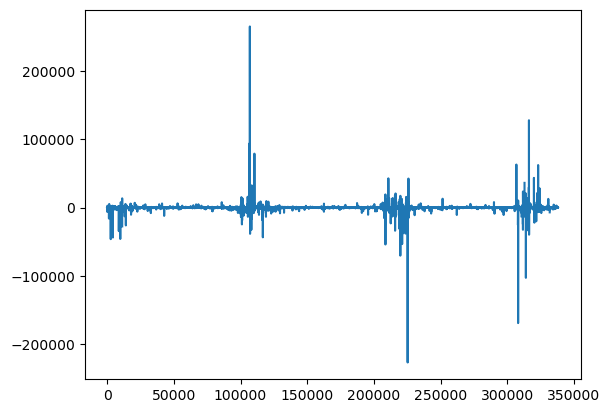

In [45]:
plt.plot(target_df['max_load'])

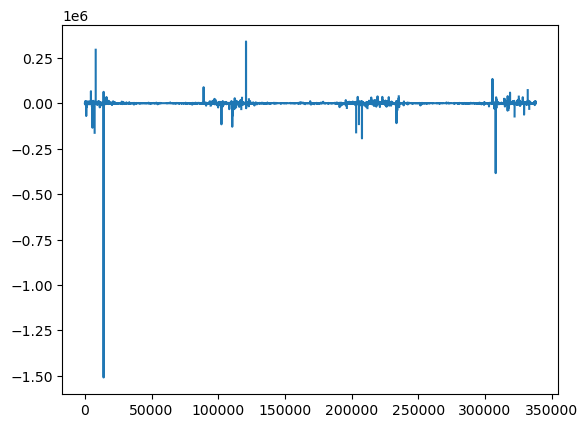

In [46]:
plt.plot(target_df['min_load'])

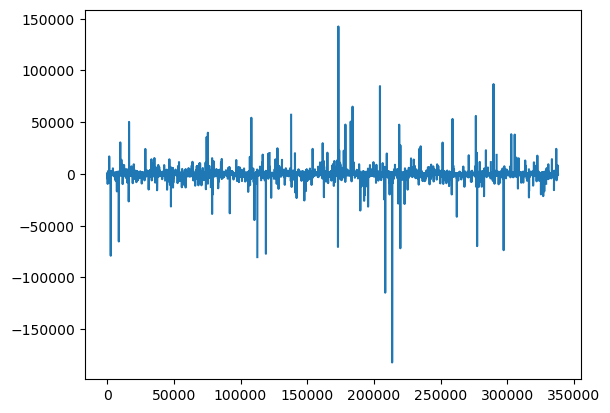

In [47]:
plt.plot(target_df['inso_load'])